In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw6.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

#### Instructions
- **THIS IS AN INDIVIDUAL ASSIGNMENT. Collaboration on this homework IS NOT PERMITTED.**
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree [21 pts]**](#part1)


- [**Question 2: Bagging [20 pts]**](#part2) 


- [**Question 3: Random Forests [14 pts]**](#part3) 


- [**Question 4: Boosting [30 pts]**](#part4) 


- [**Question 5: Understanding [15 pts]**](#part5) 
  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

In [4]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree [21 pts]</div> 
    
[Return to contents](#contents)
    

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Store the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds` respectively.
</div>

_Points:_ 7

In [5]:
train_scores = []
cvmeans = []
cvstds = []

for i in range(1,21):
    dt_1_1 = DecisionTreeClassifier(max_depth=i)
    dt_1_1.fit(X_train, y_train)
    cv_1_1 = cross_val_score(dt_1_1, X_train, y_train, cv = 5)
    
    train_scores.append(dt_1_1.score(X_train, y_train))
    cvmeans.append(np.mean(cv_1_1))
    cvstds.append(np.std(cv_1_1))

In [6]:
# len(train_scores)
# cvmeans
# cvstds

In [7]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**1.2** Now that we have `train_scores`, `cvmeans`, and `cvstds`, let's plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

_Points:_ 7

In [8]:
cvmeans_std_low = []
cvmeans_std_high = []

for i in range(0,20):
    cvmeans_std_low.append(cvmeans[i] - cvstds[i])
    cvmeans_std_high.append(cvmeans[i] + cvstds[i])

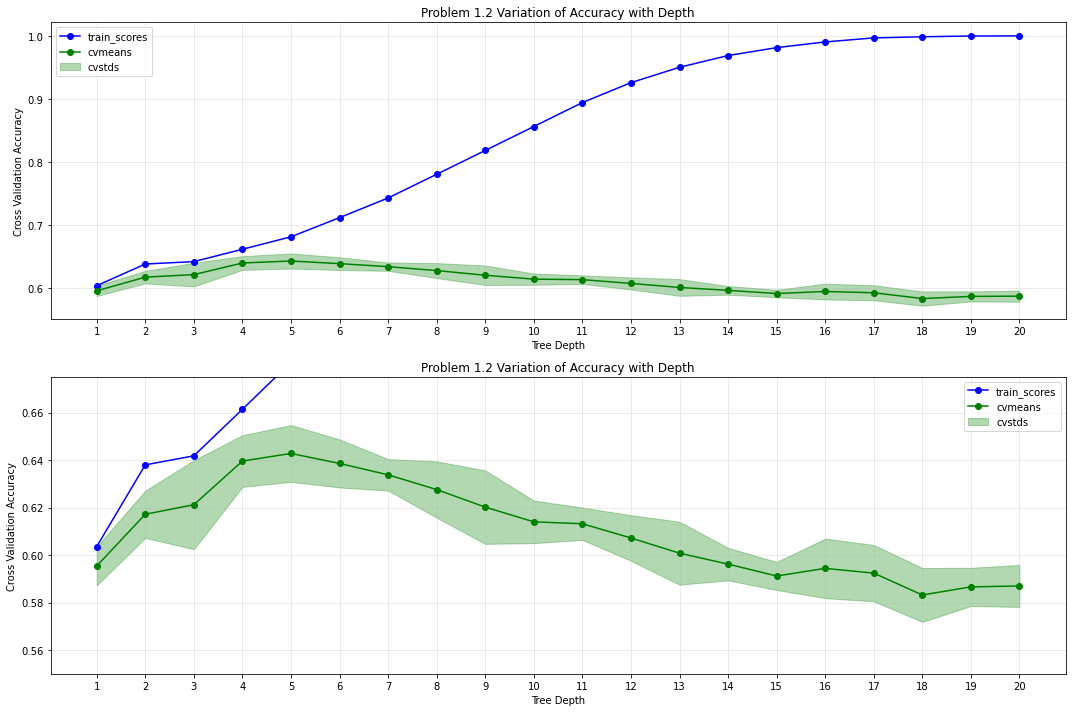

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(range(1,21), train_scores, 'b-', marker='o')
axes[0].plot(range(1,21), cvmeans, 'g-', marker='o')
axes[0].fill_between(range(1,21), (cvmeans_std_low),(cvmeans_std_high), color='green', alpha=0.3)
axes[0].set_ylabel("Cross Validation Accuracy")
axes[0].set_xlabel("Tree Depth")
axes[0].set_title('Problem 1.2 Variation of Accuracy with Depth')
axes[0].legend(['train_scores','cvmeans','cvstds'])
axes[0].grid(alpha = 0.3)
axes[0].set_xticks(range(1,21))

axes[1].plot(range(1,21), train_scores, 'b-', marker='o')
axes[1].plot(range(1,21), cvmeans, 'g-', marker='o')
axes[1].fill_between(range(1,21), (cvmeans_std_low),(cvmeans_std_high), color='green', alpha=0.3)
axes[1].set_ylabel("Cross Validation Accuracy")
axes[1].set_xlabel("Tree Depth")
axes[1].set_title('Problem 1.2 Variation of Accuracy with Depth')
axes[1].legend(['train_scores','cvmeans','cvstds'])
axes[1].grid(alpha = 0.3)
axes[1].set_ylim([0.55,0.675])
axes[1].set_xticks(range(1,21))

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, store it in `best_cv_depth`, and **justify your choice**. Then, using this depth, fit a new decision tree on the entire training data and store the train and test accuracies in `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

_Points:_ 4

1.3

- The best cv depth is 5. 
- Based on the cross-validation experiements from above we can see that when the cv is 5 the cross-validation accuracy is the highest. 
- In addition, the train scores is not the lowest out of the experiements. Therefore, the best cv depth is 5.

In [10]:
# your code here
# choose best depth after a qualitative assessment of our plots
best_cv_depth = 5

dt_1_3 = DecisionTreeClassifier(max_depth=best_cv_depth)
dt_1_3.fit(X_train, y_train)

best_cv_tree_train_score = dt_1_3.score(X_train, y_train)
best_cv_tree_test_score = dt_1_3.score(X_test, y_test)

In [11]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 5 trained on the full training set, achieves the following accuracy scores:

	train	0.6812
	TEST	0.6480


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.4** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth?

</div>

_Points:_ 3

1.4

- Since as tree depth increases, bias decreases, in other words, it may leads to over-fitting. 
- Therefore, limiting tree depth can avoid over-fitting. With a high depth, we can obtain a
model that correctly classifies all points on the boundary (by zig-zagging around each point).

- However, as the tree depth decreases or limiting the tree depth, the variance will decrease. It will leads to underfitting. Trees of low depth are robust to slight perturbations in the training data - the
square carved out by the model is stable if you move the boundary points a bit


<!-- END QUESTION -->

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging [20 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

_Points:_ 3

2.1

- Based on the dataframe 'score_2_1', we can see as tree depth increases, the train score increases, the test score decreases
- When the tree depth is 18, the test score is the lowest out of all (0.5936) the test scores and the train score is pretty high. The train score is 0.9908, almost reaching 1.0. When the tree depth is 20, the train score is 1.0, but the test score is only 0.6044. The train score is at max, yet the test score is comparatively low. Therefore, at tree depth 20, it will for sure overfit the training set. 

In [12]:
train_score_2_1 = []
test_score_2_1 = []

for i in range(1,21):
    dt_2_1 = DecisionTreeClassifier(max_depth=i)
    dt_2_1.fit(X_train, y_train)

    train_score_2_1.append(dt_2_1.score(X_train, y_train))
    test_score_2_1.append(dt_2_1.score(X_test, y_test))
    
score_2_1 = zip(range(1,21), train_score_2_1, test_score_2_1,cvmeans,cvmeans_std_low,cvmeans_std_high)
score_2_1 = pd.DataFrame(score_2_1)
score_2_1.columns = ['tree_depth','train_score_2_1','test_score_2_1','cvmeans','cvmeans_std_low','cvmeans_std_high']
score_2_1

,tree_depth,train_score_2_1,test_score_2_1,cvmeans,cvmeans_std_low,cvmeans_std_high
0,1,0.6036,0.6132,0.5954,0.587237,0.603563
1,2,0.6380,0.6444,0.6172,0.607252,0.627148
2,3,0.6418,0.6442,0.6212,0.602466,0.639934
3,4,0.6614,0.6510,0.6396,0.628708,0.650492
4,5,0.6812,0.6480,0.6428,0.630843,0.654757
5,6,0.7116,0.6486,0.6386,0.628489,0.648711
6,7,0.7428,0.6522,0.6338,0.627185,0.640415
7,8,0.7804,0.6362,0.6276,0.615741,0.639459
8,9,0.8182,0.6374,0.6202,0.604729,0.635671
9,10,0.8566,0.6244,0.6140,0.605033,0.622967


In [13]:
cv_2_1_best = np.argmax(score_2_1['cvmeans'])
cv_2_1_worst = np.argmin(score_2_1['cvmeans'])

cv_2_1_best, cv_2_1_worst

(4, 17)

In [14]:
# set overfitting tree_depth based on provided rationale 
tree_depth = 20

In [15]:
dt_2_1 = DecisionTreeClassifier(max_depth=tree_depth)
dt_2_1.fit(X_train, y_train)

train_score_2_1 = dt_2_1.score(X_train, y_train)
test_score_2_1 = dt_2_1.score(X_test, y_test)

<!-- END QUESTION -->

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- Using a random seed of 0, call the provided `bagger` function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps are returned by the `bagger` function as dataframes formatted like the example shown below. Each row represents one observation (from either the training or test set depending on the dataframe), and each column represents one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

An example of the `bagging_train_df` and `bagging_test_df` dataframes would be:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

</div>

_Points:_ 1

In [16]:
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [17]:
# specify number of required bootrapped trees
n_trees = 55 

In [18]:
bagger_2_2 = bagger(n_trees, tree_depth, X_train, y_train, X_test)

In [19]:
# cols = bagger[0].columns
# bagger[1]

bagging_train_df = bagger_2_2[0]
bagging_test_df = bagger_2_2[1]
bagging_models_list = bagger_2_2[2]

In [20]:
# generate predictions using bagger function

In [21]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1
3,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54
0,1,0,1,1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1,1
1,0,1,1,0,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0
2,1,0,1,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0
3,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,1,0


In [22]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`.

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

_Points:_ 4

In [23]:
# evaluate accuracy on our bagged prediction results
bagging_accuracy_train = np.mean(round(np.mean(bagging_train_df, axis=1))==y_train.astype(int))
bagging_accuracy_test = np.mean(round(np.mean(bagging_test_df, axis=1))==y_test.astype(int))

In [24]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 55 trees of depth-20 achieves the following accuracy scores:

	train	0.9998
	TEST	0.6846

Our prior single depth-5 tree achieved a TEST score of 0.6480.


In [25]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

</div>

_Points:_ 7

In [1]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "bagger_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


NameError: name 'pd' is not defined

In [27]:
# your code here
# generate predictions using bagger function
bagging_train_df_2_4, bagging_test_df_2_4, bagging_models_list_2_4 = bagger(
                                                            n_trees,
                                                            tree_depth,
                                                            X_train,
                                                            y_train,
                                                            X_test,
                                                            0,
                                                        )


running_correctnesss_train = running_predictions( bagging_train_df_2_4, y_train )
running_correctnesss_test = running_predictions( bagging_test_df_2_4, y_test )

Text(0.5, 1.0, '2.4 score and boots number')

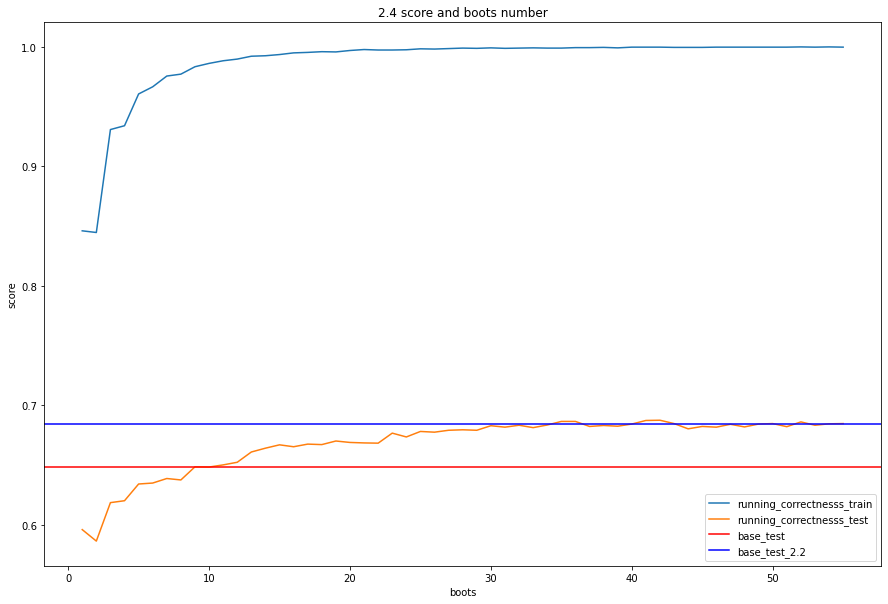

In [28]:
# your code here
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,10))

plt.plot(range(1,56),running_correctnesss_train, label='running_correctnesss_train')
plt.plot(range(1,56),running_correctnesss_test, label='running_correctnesss_test')
plt.xlabel('boots')
plt.ylabel('score')
plt.axhline(best_cv_tree_test_score,c='r', label='base_test')
plt.axhline(bagging_accuracy_test,c='b', label='base_test_2.2')
plt.legend()
plt.title('2.4 score and boots number')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain what you see in terms of the differences between how bagging and limiting tree depth work to control overfitting.

</div>

_Points:_ 5

2.5

- Looking at the graph from 2.4, compare the performance of bagging against the performance of baseline of a single tree_depth tree, we can see increasing bagging tree tree depth will increase the training score. The training score gradually increase, until reaching around 1.0. 

- However, as the bootstrap increase, the testing score does not keep on increasing. It increases until reaching "base_test_2.2", around 0.68. In other words, bagging does not help increase the testing accuracy. 

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests [14 pts]</div> 

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate classifier's accuracy on the training and test sets and store them in `random_forest_train_score` and `random_forest_test_score`.

</div>

_Points:_ 3

In [29]:
rf = RandomForestClassifier(max_depth=tree_depth,
                            n_estimators=n_trees,
                            oob_score=True,
                            max_features='sqrt')

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=55,
                       oob_score=True)

In [30]:
# evaluate results
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [31]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-20 and 55 trees achieves the following accuracy scores:

	train	1.0000
	TEST	0.6922


In [32]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series Dataframes called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.
    
**IMPORTANT:** As always, your output should be easy to interpret. In this context that means construcing your DataFrames with the care, assigning appropriate column names and/or index values to best convey to the reader what the output represents.

</div>

_Points:_ 6

In [33]:
# bagging_models_list

3.2

- Among all the decision tress fit in the bagging process, we can see the top predictors from bagging models is the same. From the "top_predictors_bagging" dataframe we can see, all the bagging model has the same value 25. For the random forest, the value of "top_predictors_rf" dataframe varies a lot, ranging from 0 to 27. 

- The process of trainign the random forest is different from bagging, and it causes the differences. All the decision trees that make up a random forest are different, because each tree is built on a different random subset of data. Random forest minimizes overfitting, it tends to be more accurate than a single decision tree.

In [34]:
# your code here

top_predictors_bagging =[]

for i in range(len(bagging_models_list)):
    top_predictors_bagging.append(bagging_models_list[i].tree_.feature[0])
    
top_predictors_bagging = pd.DataFrame(top_predictors_bagging)
top_predictors_bagging.rename(columns = {0:'top feature'}, inplace = True)
top_predictors_bagging

,top feature
0,25
1,25
2,25
3,25
4,25
5,25
6,25
7,25
8,25
9,25


In [35]:
top_predictors_bagging

,top feature
0,25
1,25
2,25
3,25
4,25
5,25
6,25
7,25
8,25
9,25


In [36]:
top_predictors_rf =[]

for i in range(len(rf)):
    rf_estimator= rf.estimators_
    top_predictors_rf.append(rf_estimator[i].tree_.feature[0])

top_predictors_rf = pd.DataFrame(top_predictors_rf)
top_predictors_rf.rename(columns = {0:'top feature'}, inplace = True)

top_predictors_rf

,top feature
0,22
1,9
2,25
3,10
4,27
5,0
6,27
7,22
8,25
9,26


In [37]:
# evaluate accuracy on our bagged prediction results


In [38]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**3.3**: Make a Pandas DataFrame (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

_Points:_ 5

3.3

- The relative performance of each model on the training set is pretty high except for the single depth -i tree chosen by CV (0.68). The rest three classifier all have around 1.0 training accuracy.  

- On the testing set, however, the test accuracy is relatively low, ranging from 0.5978 to 0.6846. 

- The relationship presented makes sense, since increasing tree depth will increase training accuracy, and decrease bias. On the other hand, increasing tree depth, will also increase varainces, since the classifier become more and more fitted to the training set. Therefore, the testing accuracy is relatively low. 

In [39]:
# your code here

results_df=pd.DataFrame([['single depth- 𝑖  tree chosen by CV',best_cv_tree_train_score, best_cv_tree_test_score ],
                         ['single overfit depth- 𝑘  tree',train_score_2_1, test_score_2_1],
                        ['bagging 55 depth- 𝑘  trees',bagging_accuracy_train, bagging_accuracy_test],
                        ['random forest of 55 depth- 𝑘  trees',random_forest_train_score,random_forest_test_score]])
results_df.columns=['classifier','training accuracy','test accuracy']

In [40]:
# display results
results_df

,classifier,training accuracy,test accuracy
0,single depth- 𝑖 tree chosen by CV,0.6812,0.6480
1,single overfit depth- 𝑘 tree,1.0000,0.5972
2,bagging 55 depth- 𝑘 trees,0.9998,0.6846
3,random forest of 55 depth- 𝑘 trees,1.0000,0.6922


<!-- END QUESTION -->

<a id="part4"></a>

## <div class='exercise'>Question 4: Boosting [30 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.1** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

_Points:_ 7

In [41]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


4.1

LOGIC: 

- tree1 is fitted on the entire dataset (X, y) instead of the training one. 
- based on the structure of the implementation, the model does not update tree or training weight it's been using the same tree all the time.
- if m > 0.5, the prediction is true and if y is also true, q +0, and the accuracy is q/len(X_train) which does not make sense


STYLE

- The implementation does not label everything with enough information, making the reader a little bit hard to understand. For instance, it is hard to differentiate the difference between tree1 and tree2. 
- The implementation also reuses a lot of variables, for instance t1p and t2p is being used in both the testing and training. 


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.2** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.1:

- Write an **excellent** example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

</div>

_Points:_ 8

In [43]:
# your code here
random_state = 0

In [44]:
def boosting_pred(X, trees):
    mean_pred_proba = sum(tree.predict_proba(X)[:, 1] for tree in trees) / len(trees)
    binary_pred = (mean_pred_proba > 0.5).astype(int)
    return binary_pred

In [45]:
# actually doing the boosting here

def boosting(X_train, y_train, X_test, y_test, num_iterations):
    result_dict = {'Train Acc': [], 'Test Acc': []}
    
    # Build the initial tree classifier with depth of 3
    tree1 = DecisionTreeClassifier(max_depth=3, random_state=random_state)
    tree1.fit(X_train, y_train)
    train_acc, test_acc = tree1.score(X_train, y_train), tree1.score(X_test, y_test)
    result_dict['Train Acc'].append(train_acc)
    result_dict['Test Acc'].append(test_acc)
    
    # save all the sequential models
    trees = [tree1]
    
    # start our boosting iteration
    for t in range(num_iterations):
        prev_train_preds = boosting_pred(X_train, trees)
        prev_test_preds = boosting_pred(X_test, trees)
        
        # determine the weight according to the previous predictions
        sample_weight = np.where(prev_train_preds == y_train, 1.0, 2.0)
        
        # fit the new weak classifier
        current_tree = DecisionTreeClassifier(max_depth=3, random_state=random_state)
        current_tree.fit(X_train, y_train, sample_weight=sample_weight)
        trees.append(current_tree)
        
        # make the predictions using the new ensemble
        train_preds = boosting_pred(X_train, trees)
        test_preds = boosting_pred(X_test, trees)
        train_acc = (train_preds == y_train).sum() / len(y_train)
        test_acc = (test_preds == y_test).sum() / len(y_test)
        result_dict['Train Acc'].append(train_acc)
        result_dict['Test Acc'].append(test_acc)
    
    result_df = pd.DataFrame(result_dict)
    result_df.index = ['Iteration ' + str(i) for i in range(1, num_iterations + 2)]
    return result_df
    
result_df = boosting(X_train, y_train, X_test, y_test, 20)
display(result_df)

,Train Acc,Test Acc
Iteration 1,0.6418,0.6442
Iteration 2,0.6488,0.6510
Iteration 3,0.6778,0.6792
Iteration 4,0.6874,0.6840
Iteration 5,0.6842,0.6796
Iteration 6,0.6982,0.6820
Iteration 7,0.6980,0.6840
Iteration 8,0.7044,0.6874
Iteration 9,0.7072,0.6860
Iteration 10,0.7100,0.6936


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.3** Now, let us use the scikit-learn implementation of AdaBoost. For the sake of simplicity we'll use a single validation split for hyperparameter tuning.
    
Use `AdaBoostClassifier` to fit another ensemble to the reduced training set, `X_train80`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and validation accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

_Points:_ 3

In [46]:
# Create a train/validation split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train,
                                                      train_size=.8,
                                                      random_state=109,
                                                      stratify=y_train)

In [47]:
# your code here
adaboost_model = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=3), 
    n_estimators=800, 
    learning_rate=0.05,
    algorithm='SAMME.R'
    
).fit(X_train80, y_train80)

y_pred_train = adaboost_model.predict(X_train80)
y_pred_test = adaboost_model.predict(X_val)

#Performance Evaluation
acc_boosting_training = accuracy_score(y_train80, y_pred_train)
acc_boosting_test = accuracy_score(y_val, y_pred_test)

In [48]:
adaboost_staged_score_train = adaboost_model.staged_score(X_train80, y_train80)
adaboost_staged_score_train = list(adaboost_staged_score_train)

adaboost_staged_score_val = adaboost_model.staged_score(X_val, y_val)
adaboost_staged_score_val = list(adaboost_staged_score_val)

Text(0.5, 1.0, '4.3 AdaBoost')

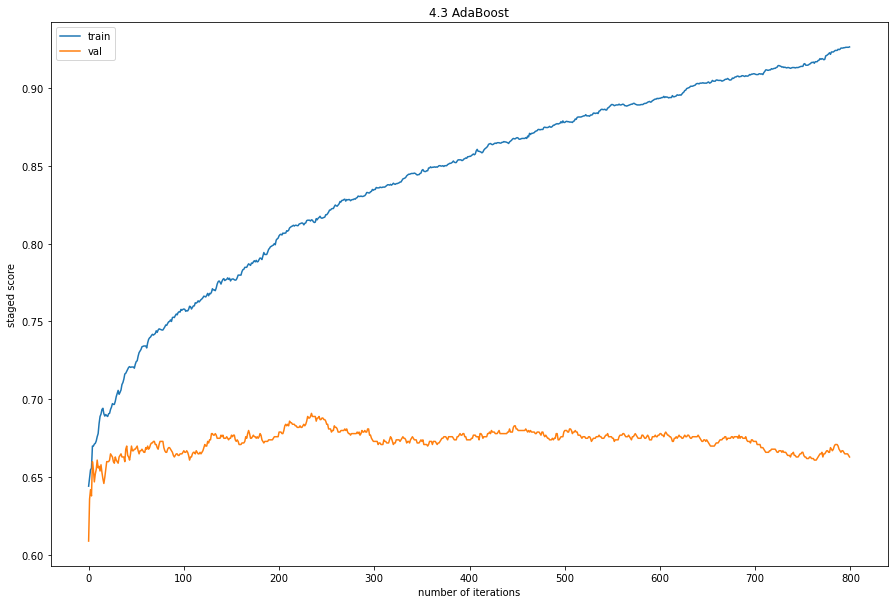

In [49]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,10))

plt.plot(range(0,800), adaboost_staged_score_train, label="train")
plt.plot(range(0,800), adaboost_staged_score_val, label="val")

plt.xlabel('number of iterations')
plt.ylabel('staged score')

plt.legend()
plt.title('4.3 AdaBoost')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.4** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. For easier comparison you should arrange your plots in a row. What trends do you see in the training and validation accuracies and how would you explain this behavior?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

_Points:_ 4

4.4

- Based on the four plot below, we can see as max depth increases the validaton accuracy remains around the range 0.6 to 0.7. However, the training accuracy gradually increases. In addition, as the number of iterations increases, the trianing accuray also increases. 

- When the max depth is 1, the triain accuracy is around the range 0.6 to 0.7. 
- When the max depth is 2, the triain accuracy is around the range 0.6 to 0.8.
- When the max depth is 3, the triain accuracy is around the range 0.6 to 0.9.
- When the max depth is 4, the triain accuracy is around the range 0.6 to 1.0.

In [50]:
# your code here

score_train = []
score_val = []


for i in range(1,5):
    adaboost_model = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=i), 
    n_estimators=800, 
    learning_rate=0.05,
    algorithm='SAMME.R').fit(X_train80, y_train80)
    
    adaboost_staged_score_train = adaboost_model.staged_score(X_train80, y_train80)
    adaboost_staged_score_train = list(adaboost_staged_score_train)
    
    score_train.append(adaboost_staged_score_train)
    
    adaboost_staged_score_val = adaboost_model.staged_score(X_val, y_val)
    adaboost_staged_score_val = list(adaboost_staged_score_val)
    
    score_val.append(adaboost_staged_score_val)

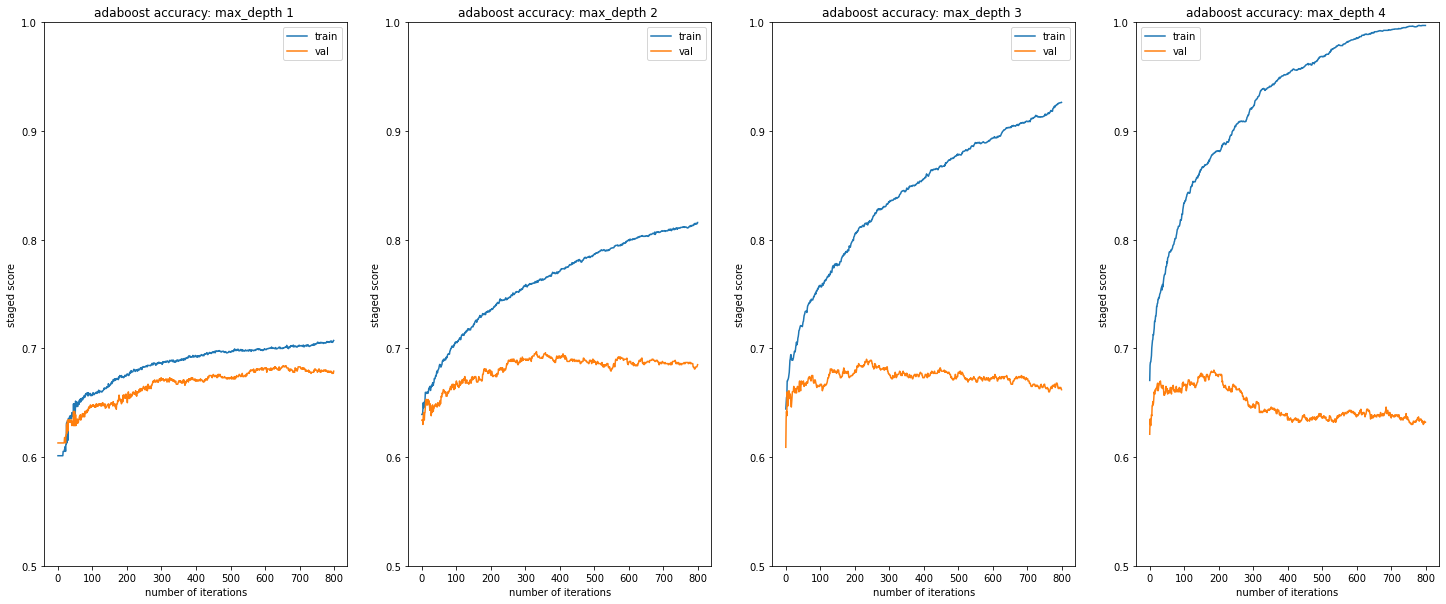

In [51]:
# your code here


fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(25,10))

for i in range(0,4):
    ax[i].plot(range(0,800), score_train[i], label="train")
    ax[i].plot(range(0,800), score_val[i], label="val")
    
    ax[i].set_xlabel('number of iterations')
    ax[i].set_ylabel('staged score')
    ax[i].legend()
    m = i+1
    ax[i].set_title('adaboost accuracy: max_depth %d ' %m)
    ax[i].set_ylim(0.5,1)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.5** Based on the plots from Question 4.4, what combination of base learner depth and the number of iterations seems optimal and why?

**Note:** Feel free to make use of additional code to make your decision here if that is helpful. 
</div>

_Points:_ 3

4.5

- Based on the plots from Question 4.4, the optimal depth is 2, and the optimal number of iterations is 332. Because at depth 2 and iteration 332, the validation score is the highest.

In [52]:
l_max = []
l_iter = []

for i in range(4):
    l_max.append(max(score_val[i]))
    l_iter.append(np.argmax(score_val[i]))
optimal_depth = np.argmax(l_max)+1
optimal_iter = l_iter[np.argmax(l_max)]

optimal_depth, optimal_iter


(2, 332)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**4.6** Fit a final AdaBoostClassifier on the **entire train set** using the base learner depth and number of iterations you identified as optimal in the previous question. Keep the learning rate at 0.05 as before. Store the train and test accuracies in `ada_train_acc` and `ada_test_acc` respectively. How does the performance of this model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

_Points:_ 5

4.6

- Based on the results, we can see the train accuracy is 76.05% and the test accuracy is 69.60%. Comparing with the ensemble method from question 2 and 3, we can see the testing accuracy is the highest out of the other methods. The training accuracy of the Ada Boost, on the other hand, is also the relatively low comparing the other methods. 

In [53]:
adaboost_model_4_6 = AdaBoostClassifier(
    base_estimator= DecisionTreeClassifier(max_depth=optimal_depth), 
    n_estimators=optimal_iter, 
    learning_rate=0.05,
    algorithm='SAMME.R'
    
).fit(X_train80, y_train80)

y_pred_train = adaboost_model_4_6.predict(X_train80)
y_pred_test = adaboost_model_4_6.predict(X_val)

In [54]:
# your code here
ada_train_acc = accuracy_score(y_train80, y_pred_train)
ada_test_acc = accuracy_score(y_val, y_pred_test)

In [55]:
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

Ada Boost Train Accuracy: 76.05%
Ada Boost Test Accuracy: 69.60%


<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Understanding [15 pts]</div> 

[Return to contents](#contents)

This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other course materials to answer these questions.
    

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

</div>

_Points:_ 5

5.1 

- Bagging and boosting are both ensemble learning methods. 
- Bagging is a method of merging the same type of predictions. Bagging decreases variance, not bias, and solves over-fitting issues in a model.
- Boosting is a method of merging different types of predictions. Boosting decreases bias, not variance.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.2** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

</div>

_Points:_ 3

5.2

- Too many trees in boosting can leads to overfitting. Too many trees in bagging can also leads to overfitting. When the tree is too deep it cuts the input space into too many regions and fit to the noise of the data so it overfits


- It is worse for bagging to have too many trees. Since the major drawback of bagging is that the averaged model is no longer easily interpretable. One can no longer trace the ‘logic’ of an output through a series of decisions based on predictor values. For each bootstrap, we build a decision tree. The result is a combination (majority) of the predictions from all trees. 


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

</div>

_Points:_ 2

5.3

- Bagging is better suited to parallelization. Since boosting combine multiple weak learners in a sequential method, which iteratively improves observations. In contrast, bagging is a parallel ensemble learning method, where each model is built independently. Therefore, bagging is better suited to parallelization. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.4** Which of these techniques can be extended to regression tasks? Describe how this can be done.

</div>

_Points:_ 5

5.4

- Bagging can be extended to regression tasks. For instance, fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions to form a final prediction. The approach can reduce the variance of estimator by introducing randomization into its construction procedure and then making an ensemble out of it.

- Boosting can also be extended to regression tasks. For instance, through gradient boosting to iteratively building a complex model T by adding simple models. Each new simple model added to the ensemble compensates for the weaknesses of the current ensemble. 

<!-- END QUESTION -->

**This concludes HW6. Thank you!**

[Return to contents](#contents)